<a href="https://colab.research.google.com/github/souravs17031999/Retinal_blindness_detection_Pytorch/blob/master/Single_test_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
# from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import time
# from tqdm import tqdm_notebook

import os

In [13]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    #torchvision.transforms.ColorJitter(brightness=2, contrast=2),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [14]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        for i in pr:
            preds.append(i.item())
            
    return preds

In [15]:
def load_model(path):
  checkpoint = torch.load(path, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [16]:
device = torch.device("cpu")

model = models.resnet152(pretrained=False) 

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

In [17]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [18]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [19]:
model = load_model("classifier.pt")


In [20]:
# def test_with_single_image(model, file, transform, classes):

#     file = Image.open(file).convert('RGB')

#     img = transform(file).unsqueeze(0)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     with torch.no_grad():
#         out = model(img.to(device))
#         ps = torch.exp(out)
#         top_p, top_class = ps.topk(1, dim=1)
#         value = top_class.item()
#         print("Value:", value)
#         print(classes[value])
#         plt.imshow(np.array(file))
#         plt.show()


def test_with_single_image(model, file, transform, classes):
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    try:
        file = Image.open(file).convert('RGB')
    except Exception as e:
        print("Image loading failed:", e)
        return

    img = transform(file).unsqueeze(0)
    device = torch.device("cpu")

    try:
        with torch.no_grad():
            out = model(img.to(device))
            ps = torch.exp(out)
            top_p, top_class = ps.topk(1, dim=1)
            value = top_class.item()
            print("Value:", value)
            print(classes[value])
            plt.imshow(np.array(file))
            plt.show()
    except Exception as e:
        print("Model inference failed:", e)

In [21]:
import random

name = "sampleimages/eye1.png"
print('Path: ', name)

Path:  sampleimages/eye1.png


Value: 2
Moderate


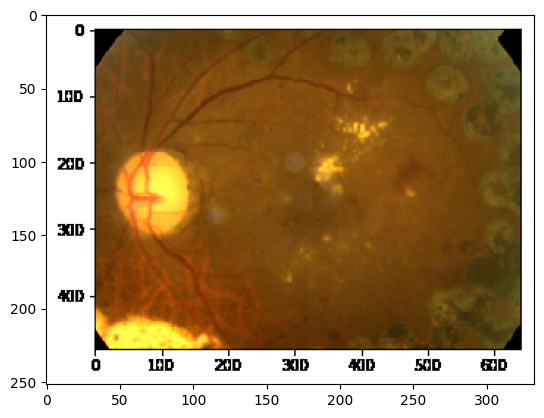

In [22]:
classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
test_with_single_image(model, name, test_transforms, classes)
